In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from kerastuner import RandomSearch
import seaborn as sns
import matplotlib.pyplot as plt


Using TensorFlow backend


C:\Users\nryas\AppData\Local\Temp\ipykernel_14376\2420600861.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [2]:
df=pd.read_excel('dataset.xlsx')
# Check for missing data in the DataFrame
missing_data = df.isnull()
# Check which columns have missing data
columns_with_missing_data = missing_data.any()
# Print the column names with missing data
print(columns_with_missing_data[columns_with_missing_data == True].index)

Index([], dtype='object')


C:\Users\nryas\AppData\Local\Temp\ipykernel_14376\3287484477.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Subscription_Length_Months', data=df, palette='Set1')


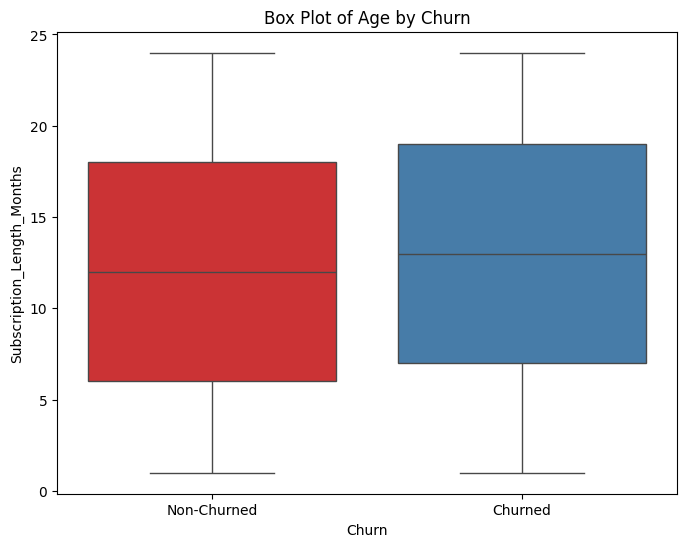

In [3]:
# Assuming you have a DataFrame named 'df' with columns 'Age' and 'Churn'
# 'Churn' is a binary variable (0 for non-churned, 1 for churned)

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='Subscription_Length_Months', data=df, palette='Set1')
plt.xlabel('Churn')
plt.ylabel('Subscription_Length_Months')
plt.title('Box Plot of Age by Churn')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])

# Show the plot
plt.show()

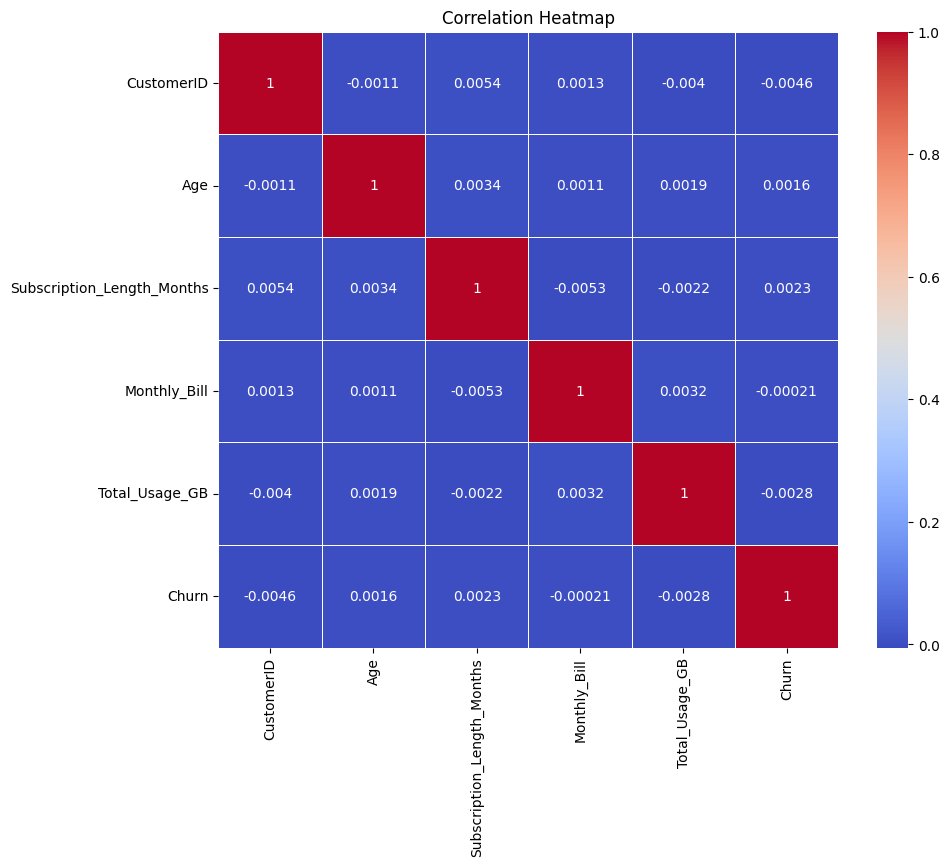

In [4]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])
# Create a correlation matrix
corr_matrix = numeric_df.corr()

# Set the figure size for the heatmap
plt.figure(figsize=(10, 8))

# Create a correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()


In [5]:
# Check unique values in the 'Location' column
unique_locations = df['Location'].unique()

# Assess if 'Location' is categorical based on the number of unique values
if len(unique_locations) < len(df) * 0.05:  # A common threshold for categorical features
    print("Location is likely a categorical feature.")
else:
    print("Location may not be a categorical feature.")
    
# Use one-hot encoding to create binary columns for each unique location
df = pd.get_dummies(df, columns=['Location'], prefix=['Location'])
df = df.replace({True: 1, False: 0})
# Print the modified DataFrame to see the changes
print(df.head())


Location is likely a categorical feature.
   CustomerID        Name  Age  Gender  Subscription_Length_Months  \
0           1  Customer_1   63    Male                          17   
1           2  Customer_2   62  Female                           1   
2           3  Customer_3   24  Female                           5   
3           4  Customer_4   36  Female                           3   
4           5  Customer_5   46  Female                          19   

   Monthly_Bill  Total_Usage_GB  Churn  Location_Chicago  Location_Houston  \
0         73.36             236      0                 0                 0   
1         48.76             172      0                 0                 0   
2         85.47             460      0                 0                 0   
3         97.94             297      1                 0                 0   
4         58.14             266      0                 0                 0   

   Location_Los Angeles  Location_Miami  Location_New York  
0      

In [6]:
# Age Groups
bins = [0, 18, 35, 60, float("inf")]
labels = ['Youth', 'Young Adult', 'Adult', 'Senior']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Gender Encoding (assuming 'Gender' is binary)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Calculate churn frequency for each location
location_churn_frequencies = df.groupby(['Location_Chicago', 'Location_Houston', 'Location_Los Angeles', 'Location_Miami', 'Location_New York'])['Churn'].mean().reset_index()

# Rename columns for clarity
location_churn_frequencies = location_churn_frequencies.rename(columns={'Churn': 'Churn_Frequency'})

# Outlier Indicators
#monthly_bill_outlier = df['Monthly_Bill'].mean() + 2 * df['Monthly_Bill'].std()  # Example: Define outlier threshold
#total_usage_outlier = df['Total_Usage_GB'].mean() + 2 * df['Total_Usage_GB'].std()  # Example: Define outlier threshold
#df['Monthly_Bill_Outlier'] = (df['Monthly_Bill'] > monthly_bill_outlier).astype(int)
#df['Total_Usage_Outlier'] = (df['Total_Usage_GB'] > total_usage_outlier).astype(int)

# Subscription Length vs. Age
#df['Subscription_Length_Age'] = df['Subscription_Length_Months'] / df['Age']

# Usage per Day
df['Usage_Per_Day'] = df['Total_Usage_GB'] / df['Subscription_Length_Months'] / 30  # Assuming an average month has 30 days

# Print the modified DataFrame to see the changes
display(df)

,CustomerID,Name,Age,Gender,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,Age_Group,Usage_Per_Day
0,1,Customer_1,63,0,17,73.36,236,0,0,0,1,0,0,Senior,0.462745
1,2,Customer_2,62,1,1,48.76,172,0,0,0,0,0,1,Senior,5.733333
2,3,Customer_3,24,1,5,85.47,460,0,0,0,1,0,0,Young Adult,3.066667
3,4,Customer_4,36,1,3,97.94,297,1,0,0,0,1,0,Adult,3.300000
4,5,Customer_5,46,1,19,58.14,266,0,0,0,0,1,0,Adult,0.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,Customer_99996,33,0,23,55.13,226,1,0,1,0,0,0,Young Adult,0.327536
99996,99997,Customer_99997,62,1,19,61.65,351,0,0,0,0,0,1,Senior,0.615789
99997,99998,Customer_99998,64,0,17,96.11,251,1,1,0,0,0,0,Senior,0.492157
99998,99999,Customer_99999,51,1,20,49.25,434,1,0,0,0,0,1,Adult,0.723333


In [7]:
# Use one-hot encoding to create binary columns for each unique location
df = pd.get_dummies(df, columns=['Age_Group'], prefix=['Age_Group'])
df = df.replace({True: 1, False: 0})
# Print the modified DataFrame to see the changes
print(df.head())



   CustomerID        Name  Age  Gender  Subscription_Length_Months  \
0           1  Customer_1   63       0                          17   
1           2  Customer_2   62       1                           1   
2           3  Customer_3   24       1                           5   
3           4  Customer_4   36       1                           3   
4           5  Customer_5   46       1                          19   

   Monthly_Bill  Total_Usage_GB  Churn  Location_Chicago  Location_Houston  \
0         73.36             236      0                 0                 0   
1         48.76             172      0                 0                 0   
2         85.47             460      0                 0                 0   
3         97.94             297      1                 0                 0   
4         58.14             266      0                 0                 0   

   Location_Los Angeles  Location_Miami  Location_New York  Usage_Per_Day  \
0                     1          

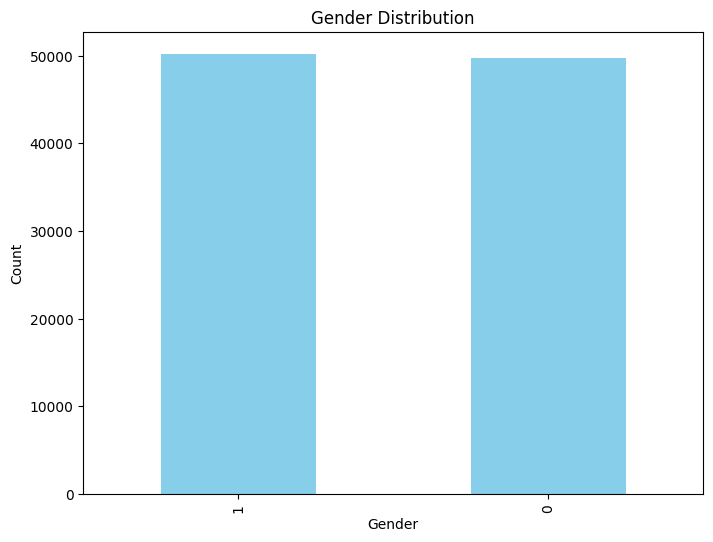

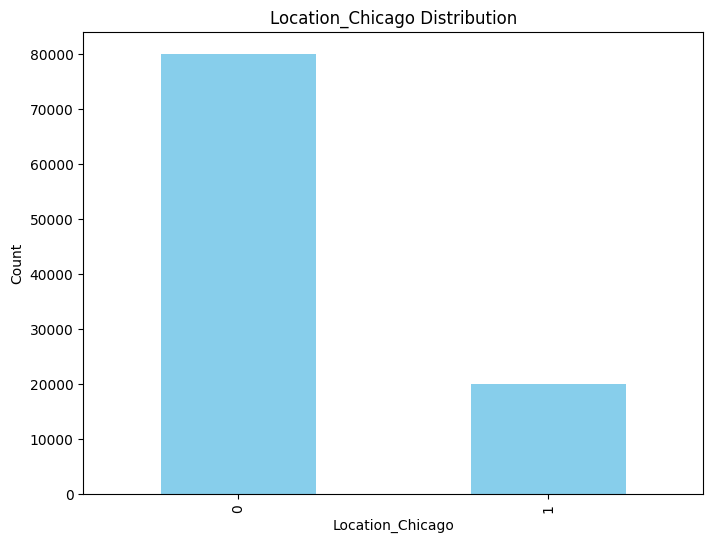

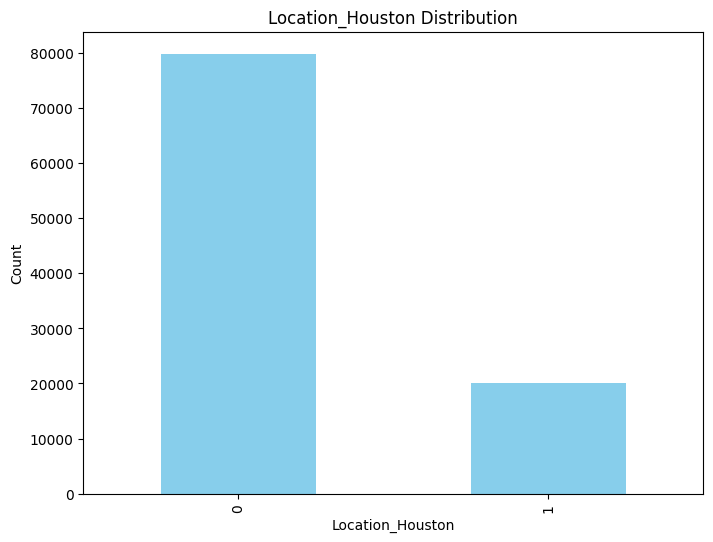

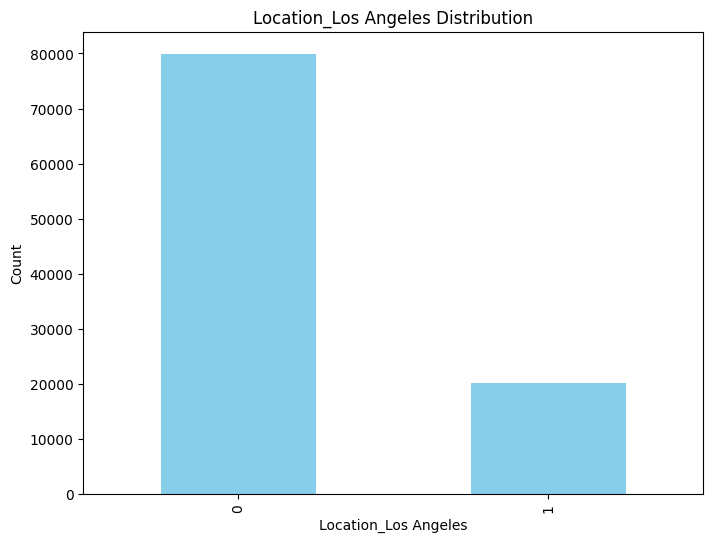

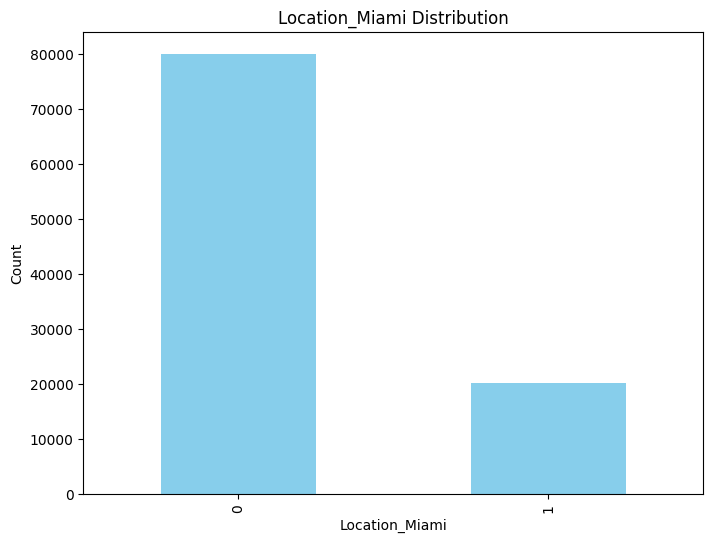

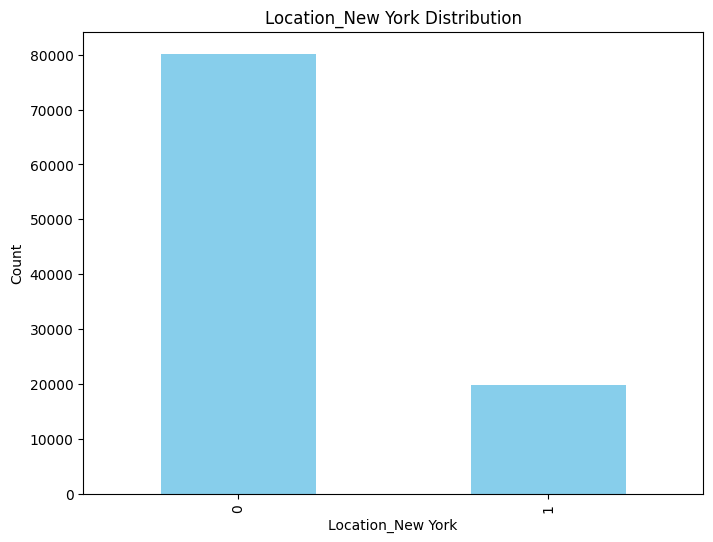

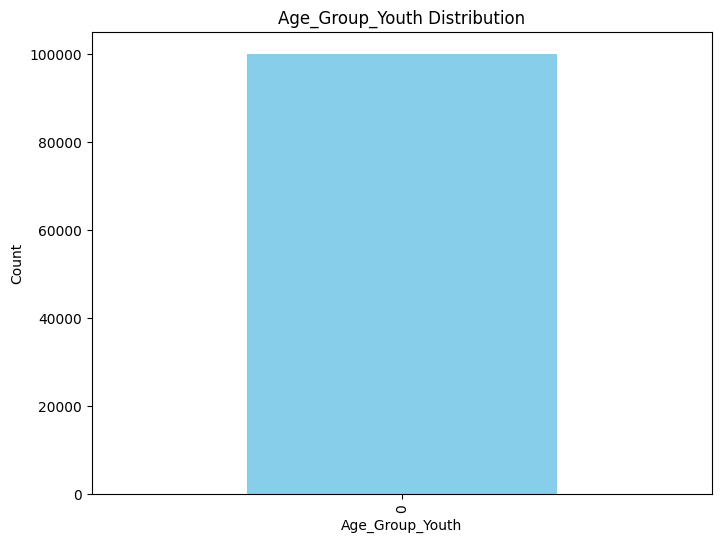

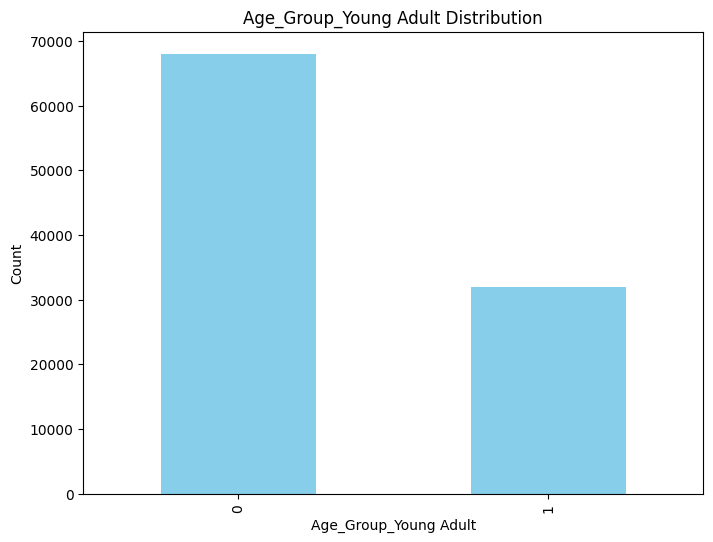

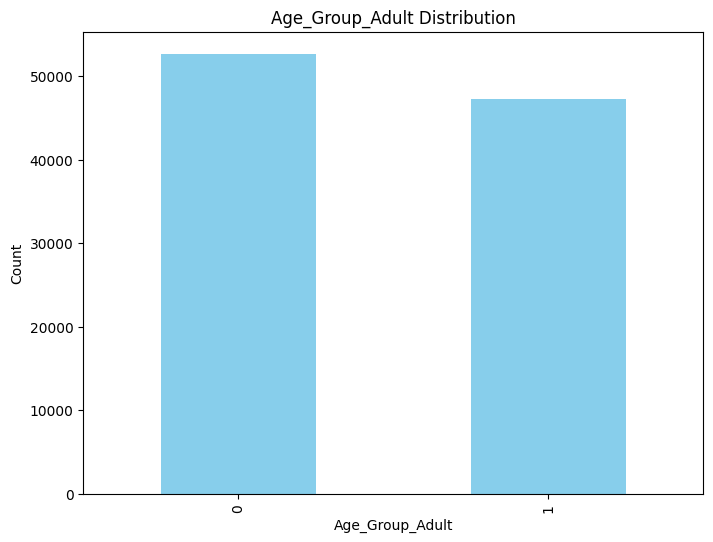

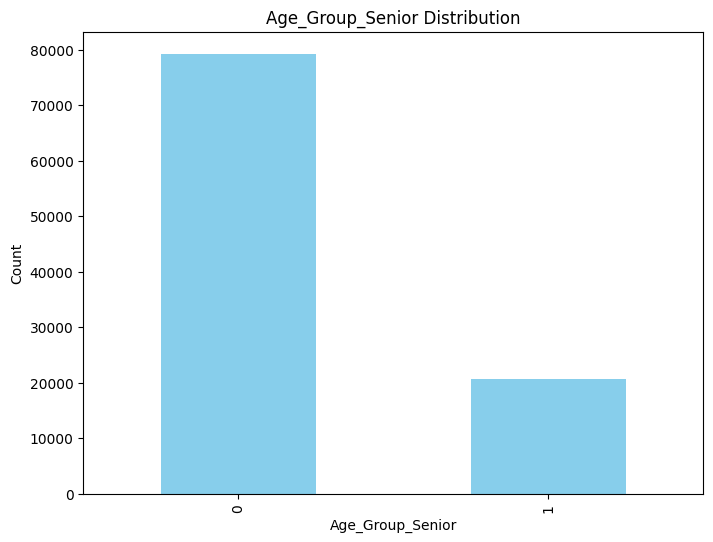

In [8]:
categorical_columns = ['Gender', 'Location_Chicago', 'Location_Houston', 'Location_Los Angeles', 'Location_Miami', 'Location_New York', 'Age_Group_Youth',  'Age_Group_Young Adult',  'Age_Group_Adult', 'Age_Group_Senior']

# Create bar charts for each categorical column
for column in categorical_columns:
    # Count the occurrences of each category
    category_counts = df[column].value_counts()
    
    # Create a bar chart
    plt.figure(figsize=(8, 6))
    category_counts.plot(kind='bar', color='skyblue')
    
    # Set labels and title
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'{column} Distribution')
    
    # Show the plot
    plt.show()

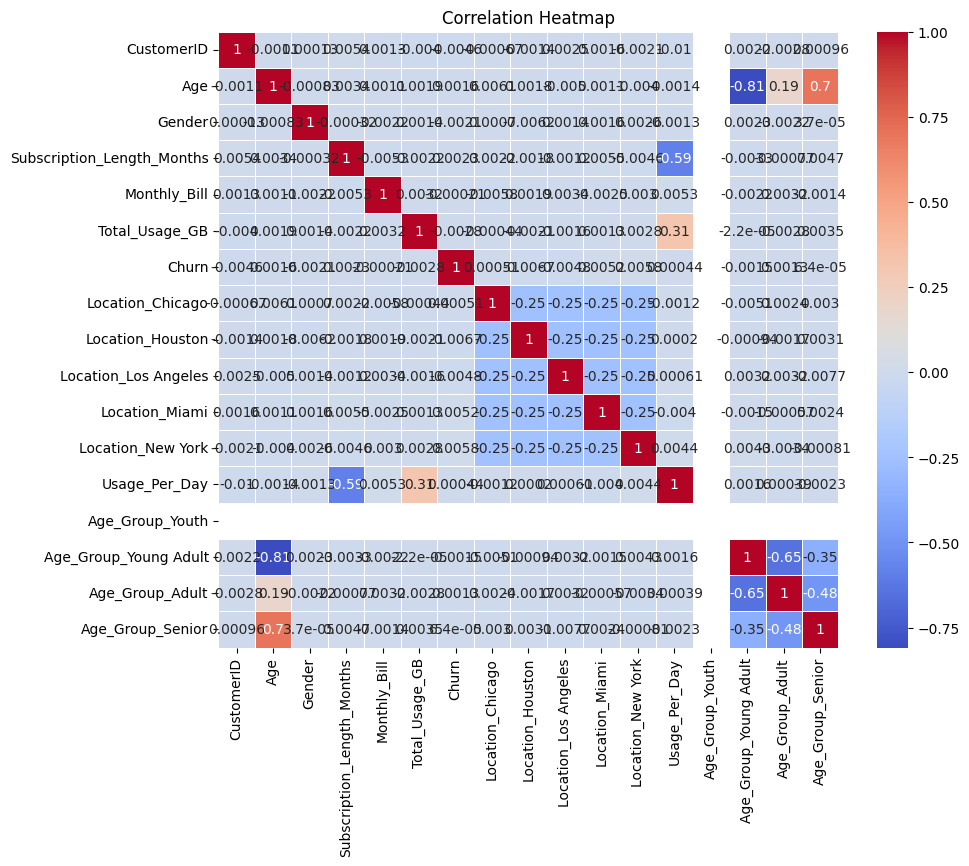

In [9]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

#Dropping Age_group_Youth column as it is not neccessary
df = df.drop('Age_Group_Youth', axis=1)

# Create a correlation matrix
corr_matrix = numeric_df.corr()

# Set the figure size for the heatmap
plt.figure(figsize=(10, 8))

# Create a correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

In [10]:
# Create X (features) by selecting the columns you want to use for prediction
print(df.columns)
X = df[['Gender', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Location_Chicago',
       'Location_Houston', 'Location_Los Angeles', 'Location_Miami',
       'Location_New York', 'Usage_Per_Day', 'Age_Group_Young Adult', 'Age_Group_Adult', 'Age_Group_Senior']]
# Create y (target variable) by selecting the 'Churn' column
y = df['Churn']

display(X)

Index(['CustomerID', 'Name', 'Age', 'Gender', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn', 'Location_Chicago',
       'Location_Houston', 'Location_Los Angeles', 'Location_Miami',
       'Location_New York', 'Usage_Per_Day', 'Age_Group_Young Adult',
       'Age_Group_Adult', 'Age_Group_Senior'],
      dtype='object')


,Gender,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,Usage_Per_Day,Age_Group_Young Adult,Age_Group_Adult,Age_Group_Senior
0,0,17,73.36,236,0,0,1,0,0,0.462745,0,0,1
1,1,1,48.76,172,0,0,0,0,1,5.733333,0,0,1
2,1,5,85.47,460,0,0,1,0,0,3.066667,1,0,0
3,1,3,97.94,297,0,0,0,1,0,3.300000,0,1,0
4,1,19,58.14,266,0,0,0,1,0,0.466667,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,23,55.13,226,0,1,0,0,0,0.327536,1,0,0
99996,1,19,61.65,351,0,0,0,0,1,0.615789,0,0,1
99997,0,17,96.11,251,1,0,0,0,0,0.492157,0,0,1
99998,1,20,49.25,434,0,0,0,0,1,0.723333,0,1,0


In [11]:
# Check class distribution
class_distribution = df['Churn'].value_counts()
# Print the distribution
print(class_distribution)
#Balanced Classes so we are using random split method
from sklearn.model_selection import train_test_split
# Perform stratified data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

display(X_train)


Churn
0    50221
1    49779
Name: count, dtype: int64


,Gender,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,Usage_Per_Day,Age_Group_Young Adult,Age_Group_Adult,Age_Group_Senior
22380,1,12,48.05,204,0,0,0,0,1,0.566667,0,0,1
28629,0,12,56.20,202,0,1,0,0,0,0.561111,1,0,0
41002,1,16,63.97,151,0,1,0,0,0,0.314583,1,0,0
27398,0,10,91.27,285,1,0,0,0,0,0.950000,0,1,0
67113,0,20,31.91,197,0,0,0,0,1,0.328333,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36762,0,14,94.59,347,0,0,0,0,1,0.826190,0,1,0
73624,1,9,56.26,222,0,0,0,0,1,0.822222,0,1,0
28401,0,15,65.69,468,0,0,1,0,0,1.040000,1,0,0
81001,1,20,43.72,318,0,0,0,1,0,0.530000,0,0,1


In [17]:
# Train and evaluate scikit-learn's logistic regression
sklearn_model = SklearnLogisticRegression()
sklearn_model.fit(X_train, y_train)
y_train_pred = sklearn_model.predict(X_train)
y_test_pred = sklearn_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you've already trained the 'sklearn_model' and have predictions 'y_train_pred' and 'y_test_pred'

# Calculate Precision, Recall, and F1-Score for the training data
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Calculate Precision, Recall, and F1-Score for the test data
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the results

print("Scikit-Learn Train Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Scikit-Learn Test Accuracy: {:.2f}%".format(test_accuracy * 100))

print("Scikit-Learn Train Precision: {:.2f}".format(train_precision))
print("Scikit-Learn Train Recall: {:.2f}".format(train_recall))
print("Scikit-Learn Train F1-Score: {:.2f}".format(train_f1))

print("Scikit-Learn Test Precision: {:.2f}".format(test_precision))
print("Scikit-Learn Test Recall: {:.2f}".format(test_recall))
print("Scikit-Learn Test F1-Score: {:.2f}".format(test_f1))

Scikit-Learn Train Accuracy: 50.66%
Scikit-Learn Test Accuracy: 49.78%
Scikit-Learn Train Precision: 0.50
Scikit-Learn Train Recall: 0.47
Scikit-Learn Train F1-Score: 0.49
Scikit-Learn Test Precision: 0.50
Scikit-Learn Test Recall: 0.46
Scikit-Learn Test F1-Score: 0.48


In [12]:
# Normalize features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)


Epoch 1/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6969 - accuracy: 0.5005 - val_loss: 0.6946 - val_accuracy: 0.5044
Epoch 2/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6942 - accuracy: 0.5043 - val_loss: 0.6940 - val_accuracy: 0.5008
Epoch 3/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6935 - accuracy: 0.5097 - val_loss: 0.6939 - val_accuracy: 0.5019
Epoch 4/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6931 - accuracy: 0.5091 - val_loss: 0.6934 - val_accuracy: 0.5040
Epoch 5/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6935 - val_accuracy: 0.5004
Epoch 6/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6929 - accuracy: 0.5114 - val_loss: 0.6937 - val_accuracy: 0.4988
Epoch 7/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6928 - accuracy: 0.5098 - val_loss: 0.6935 - val_accuracy:

In [15]:
 # Normalize features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def build_model(hp):
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(units=hp.Int('units_1', min_value=32, max_value=128, step=32), activation='relu'),
        layers.Dense(units=hp.Int('units_2', min_value=16, max_value=64, step=16), activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparameter_tuning'
)

tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)


Trial 10 Complete [00h 01m 37s]
val_accuracy: 0.5071874856948853

Best val_accuracy So Far: 0.5130937397480011
Total elapsed time: 16h 49m 30s
625/625 [==============================] - 1s 2ms/step
Accuracy: 0.50
Precision: 0.50
Recall: 0.31
F1-score: 0.38
Confusion Matrix:
[[7022 3022]
 [6906 3050]]


In [16]:
# Standardize/normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the neural network model
def create_model():
    model = keras.Sequential([
        layers.Input(shape=X.shape[1]),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy: {scores[1]:.2f}")
    cvscores.append(scores[1])

print(f"Mean Accuracy: {np.mean(cvscores):.2f} (+/- {np.std(cvscores):.2f})")

Accuracy: 0.50
Accuracy: 0.50
Accuracy: 0.51
Accuracy: 0.49
Accuracy: 0.50
Mean Accuracy: 0.50 (+/- 0.00)
